In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import colors_iterator
from DS_models_stat import cut_cat
from DS_Planck_Unet import val_pix, west_val, east_val
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
%config InlineBackend.figure_format = 'retina'

In [2]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = {os.path.splitext(os.path.basename(s))[0] : os.path.join(dirname, s) for s in true_cats}
true_cats['PSZ2(z)'] = '/home/rt2122/Data/clusters/planck_z.csv'
true_cats['eROSITA'] = '/home/rt2122/Data/SRGz/clusters/clusters1_b20_edit.csv'
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

In [3]:
def make_histogram(ax, counts_list, bins, label_list=None, coef_list=None, log=True, add_legend=True, title=''):
    if coef_list is None:
        coef_list = [1] * len(counts_list)
    if label_list is None:
        label_list = [''] * len(counts_list)
    
    ci = colors_iterator()
    for i, counts in enumerate(counts_list):
         ax.hist(bins[:-1], bins, weights=counts * coef_list[i], 
                  histtype='step', log=log, label=label_list[i], color=next(ci))
    ax.set_title(title)
    if add_legend:
        ax.legend(loc='upper left')

In [4]:
class Counts_cat:
    def __init__(self, bins, name, found_counts, error_counts, alls, found_coef, err_coef):
        self.bins = bins
        self.name = name
        self.found_counts = found_counts
        self.error_counts = error_counts
        self.alls = alls
        self.found_coef = found_coef
        self.err_coef = err_coef
        self.found = found_counts/found_coef
        self.error = error_counts/err_coef
        
    def error_for_all(self):
        return np.nan_to_num(self.error_counts/self.alls)
    
    def err_ratio(self):
        return np.nan_to_num(self.error / self.found)
    def precision(self):
        return np.nan_to_num(self.found_counts / self.alls)
    def corr_precision(self):
        return (1 - self.err_ratio()) * self.precision()

In [5]:
def found_all_error_calculated(det_cat, true_cat, small_rads=[0, 400], big_rads=[1000, 1500], saving=None, n_bins=20, func_cat=None,
                              with_tqdm=False, name=''):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
        
        iterator = range(len(det_cat))
        if with_tqdm:
            iterator = tqdm(iterator)

        for i in iterator:
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(np.logical_and(angle1/3600 <= sep, sep < angle2/3600))
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

        return colored
    
    def square(rads):
        return np.pi * (rads[1] ** 2 - rads[0] ** 2)
    
    if not (func_cat is None):
        det_cat = func_cat(det_cat)
        true_cat = func_cat(true_cat)
    
    found = func(*small_rads, det_cat, true_cat)
    error = func(*big_rads, det_cat, true_cat)
    
    small_sq = square(small_rads)
    big_sq = square(big_rads)
    
    bins = np.arange(0, 1 + 1/n_bins, 1/n_bins)
    
    found_counts, _ = np.histogram(found, bins)
    error_counts, _ = np.histogram(error, bins)
    all_counts, _ = np.histogram(det_cat['max_pred'], bins)
    
    cc = Counts_cat(bins=bins, name=name, found_counts=found_counts, error_counts=error_counts, alls=all_counts, found_coef=small_sq, 
                   err_coef=big_sq)
    return cc

In [6]:
#counts_b20 = {}
counts = {}
n_bins = 10
for cat_name in tqdm(['MCXC', 'ACT', 'PSZ2(z)', 'eROSITA']):
    #cc = found_all_error_calculated(cut_cat(pd.read_csv(det_cat), dict_cut={'b' : [20, np.inf]}), 
    #                                cut_cat(pd.read_csv(true_cats[cat_name]), dict_cut={'b' : [20, np.inf], 'l' : [0, 180]}), 
    #                                n_bins=n_bins,
    #                               name=cat_name) 
    #counts_b20[cat_name] = cc
    cc = found_all_error_calculated(pd.read_csv(det_cat), 
                                    pd.read_csv(true_cats[cat_name]), n_bins=n_bins, name=cat_name) 
    counts[cat_name] = cc

KeyboardInterrupt: 

In [ ]:
def make_plot(ax, counts_list, bins, label_list=None, log=True, add_legend=True, title='', grid=True):
    if label_list is None:
        label_list = [''] * len(counts_list)
    
    ci = colors_iterator()
    st = ['-', '--', '.-']
    for i, counts in enumerate(counts_list):
        l, = ax.plot(bins[:-1] + (bins[1] - bins[0])/2, counts, c=next(ci), linestyle=st[i % len(st)])
        l.set_label(label_list[i])
    ax.set_title(title)
    if log:
        plt.yscale('log')
    if add_legend:
        ax.legend(loc='upper left')
    if grid:
        ticks = np.array([10 **  i for i in range(3)])
        ax.set_yticks(ticks, minor=False)
        ax.set_yticks(ticks + ticks * 0.5 + ticks * 0.25 + ticks* 0.75, minor=True)
        ax.grid(linestyle=':', axis='both', which='minor', alpha=0.5)
        ax.grid(linestyle=':', axis='both', which='major')

In [27]:
selected =  ['PSZ2(z)', 'MCXC', 'ACT', 'eROSITA']
def plot_hist_show(ax, cc, cat_name, title):
    ax.set_xlim([0.1, 1])
    ax.set_ylim([1, 1000])
    ax.set_ylabel('number of objects')
    ax.set_xlabel('p_{max}')
    make_plot(ax, [cc.found_counts, 
                      cc.found_counts - cc.error_counts * cc.found_coef/ cc.err_coef], cc.bins, 
                   label_list=[cat_name, 'Corrected ' + cat_name], log=True, add_legend=True, 
             title=title)

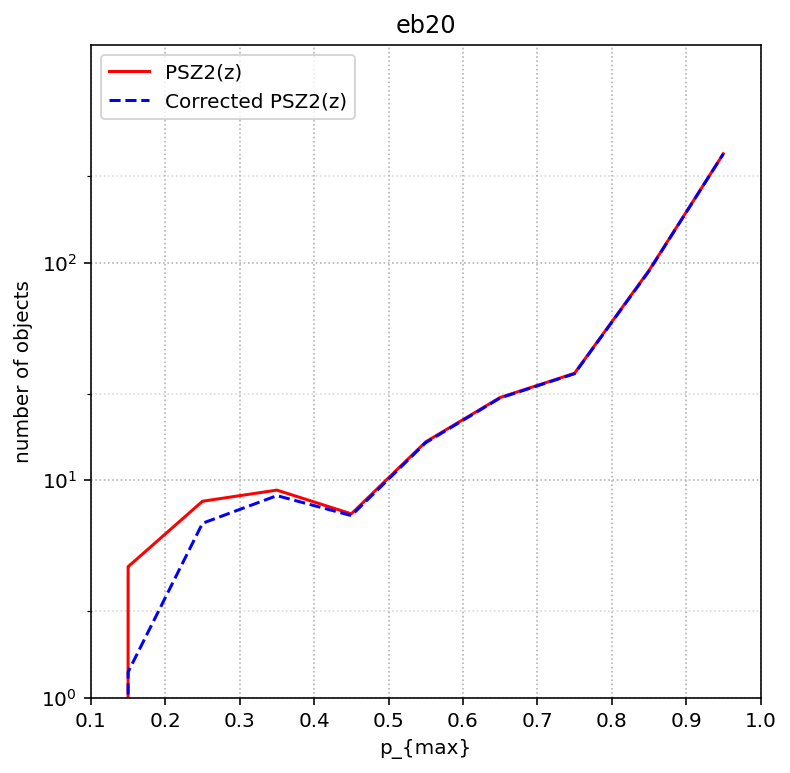

In [28]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
catname = 'PSZ2(z)'
title='eb20'
plot_hist_show(ax, counts_b20[catname], catname, title)

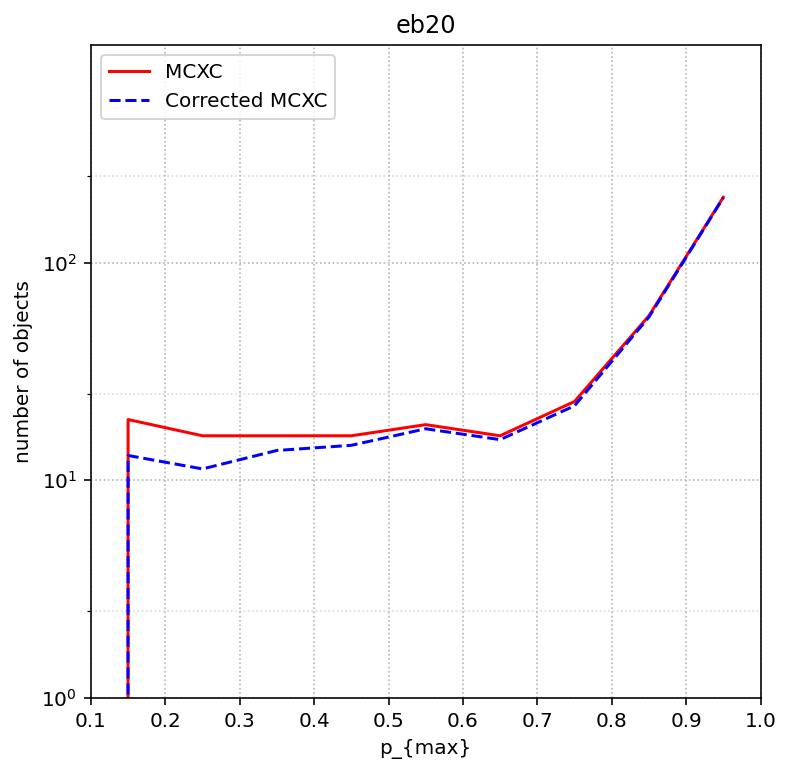

In [29]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
name='MCXC'
plot_hist_show(ax, counts_b20[name], name, title)

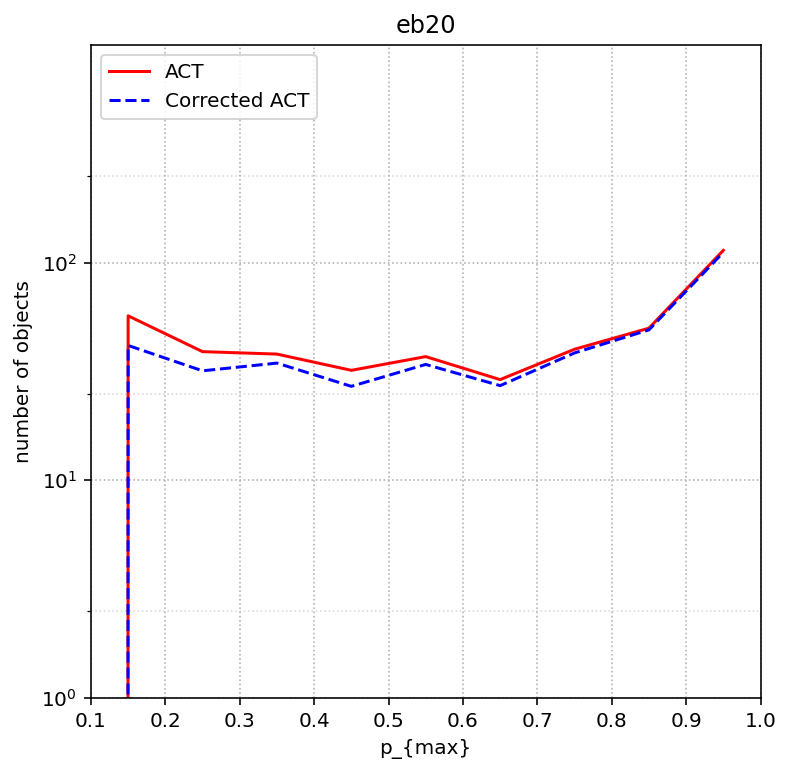

In [30]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
name='ACT'
plot_hist_show(ax, counts_b20[name], name, title)

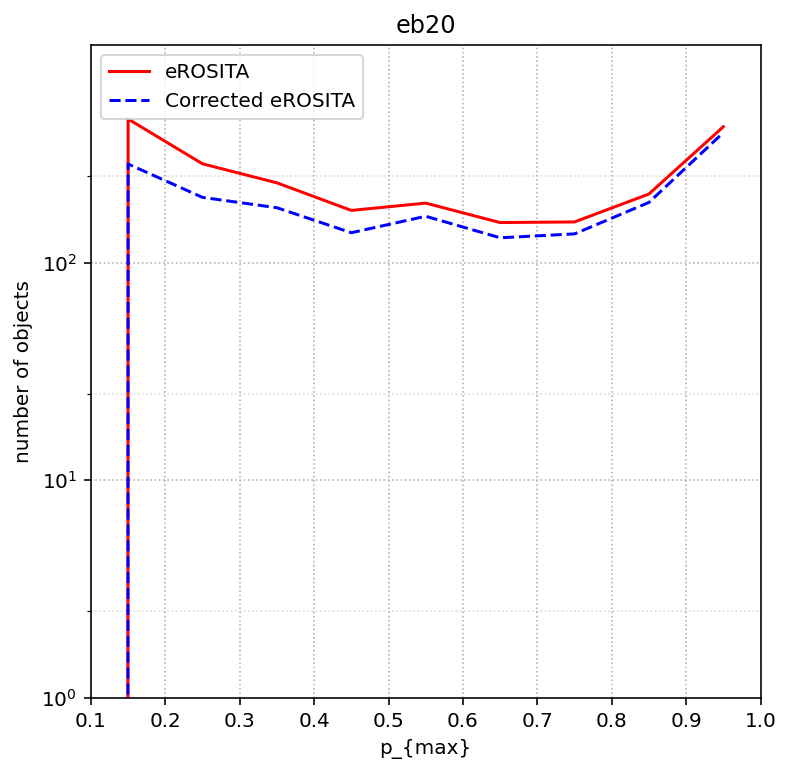

In [31]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
name='eROSITA'
plot_hist_show(ax, counts_b20[name], name, title)